In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils import *

# Data

## Basic parameters

In [2]:
data_path = 'data/'
train_ratio = 0.8
valid_ratio = 0.2
batch_size = 128

## Dataset

In [3]:
transform = transforms.Compose([transforms.Resize([32, 32]),
                                transforms.Grayscale(),
                                transforms.RandomHorizontalFlip(),  # data augmentation
                                transforms.RandomRotation(10),  # data augmentation
                                transforms.ToTensor()])

dataset = ImageFolder(data_path, transform=transform)

In [4]:
classes = dataset.classes
print('Total images:', len(dataset))
print('Total classes:', len(classes))

Total images: 10160
Total classes: 10


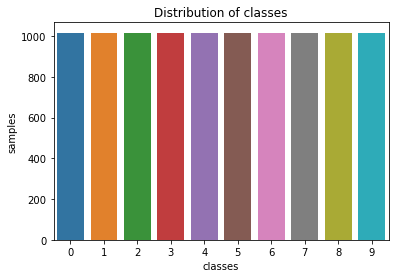

In [5]:
samples_by_class = num_class(dataset)
sns.barplot(x=list(samples_by_class.keys()), y=list(samples_by_class.values()))
plt.title('Distribution of classes')
plt.xlabel('classes')
plt.ylabel('samples');

### Split dataset

In [6]:
train_idx, valid_idx, test_idx = train_valid_test(dataset, train_ratio=0.8, valid_ratio=0.2)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

print('Train:', len(train_sampler))
print('Valid:', len(valid_sampler))
print('Test:', len(test_sampler))

Train: 6096
Valid: 2032
Test: 2032


## Dataloaders

In [7]:
data_loaders = {
    'train': DataLoader(dataset, sampler=train_sampler, batch_size=batch_size),
    'valid': DataLoader(dataset, sampler=valid_sampler, batch_size=batch_size),
    'test': DataLoader(dataset, sampler=test_sampler, batch_size=batch_size)
            }

### Visualize img example

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1d90d6bc2c8>)

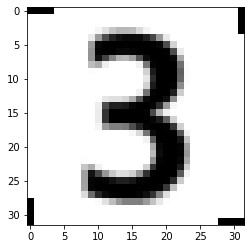

In [8]:
images, labels = iter(data_loaders['train']).next()
images = images.numpy()
img = images[0].squeeze()
plt.figure(), plt.imshow(img, cmap='gray')

# CNN architecture

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(8 * 8 * 32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Training

In [10]:
model = Classifier()
print(model)

# CPU/GPU settings
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on {}'.format(device.type))
model = model.to(device)

Classifier(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
Training on cuda


In [11]:
epochs = 20
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_loss, valid_loss, valid_acc = train_model(epochs, model, data_loaders, criterion, optimizer, device)

Epoch: 1/20
----------
Train loss:1.87  Valid loss:0.891  Valid acc:74.8%

Epoch: 2/20
----------
Train loss:0.604  Valid loss:0.397  Valid acc:88.3%

Epoch: 3/20
----------
Train loss:0.363  Valid loss:0.349  Valid acc:90.0%

Epoch: 4/20
----------
Train loss:0.279  Valid loss:0.258  Valid acc:91.8%

Epoch: 5/20
----------
Train loss:0.243  Valid loss:0.21  Valid acc:94.7%

Epoch: 6/20
----------
Train loss:0.189  Valid loss:0.17  Valid acc:95.4%

Epoch: 7/20
----------
Train loss:0.174  Valid loss:0.185  Valid acc:94.6%

Epoch: 8/20
----------
Train loss:0.165  Valid loss:0.147  Valid acc:95.5%

Epoch: 9/20
----------
Train loss:0.134  Valid loss:0.136  Valid acc:96.5%

Epoch: 10/20
----------
Train loss:0.128  Valid loss:0.122  Valid acc:96.5%

Epoch: 11/20
----------
Train loss:0.121  Valid loss:0.128  Valid acc:96.3%

Epoch: 12/20
----------
Train loss:0.104  Valid loss:0.0985  Valid acc:97.2%

Epoch: 13/20
----------
Train loss:0.0979  Valid loss:0.0965  Valid acc:97.1%

Epoch: 1

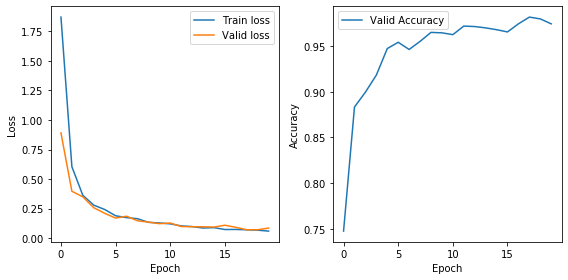

In [12]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(valid_acc, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout();

# Test

In [13]:
state_dict = torch.load('classifier_digit.pt')
model.load_state_dict(state_dict)
test_acc, class_acc = test_model(classes, model, data_loaders, device)


TEST
Test accuracy of 0: 99.5%
Test accuracy of 1: 96.4%
Test accuracy of 2: 99.5%
Test accuracy of 3: 98.2%
Test accuracy of 4: 99.5%
Test accuracy of 5: 96.7%
Test accuracy of 6: 99.5%
Test accuracy of 7: 99.0%
Test accuracy of 8: 93.4%
Test accuracy of 9: 98.2%

Global accuracy: 98.0%


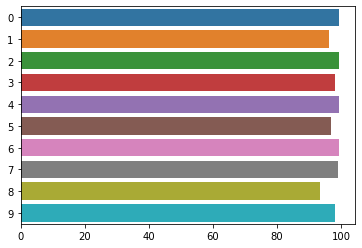

In [14]:
sns.barplot(y=classes, x=[ii*100 for ii in class_acc]);